## Import

In [180]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import yfinance as yf

## My Portfolio's repartition

In [181]:
# Liste des symboles des actions et leur répartition en pourcentage
portfolio = {
    'AAPL': 15,
    'MSFT': 15,
    'AMZN': 15,
    'MC.PA': 15,
    'TTE.PA': 15,
    'GOOGL': 15,
    'META': 10,
}

investment_amout = 1000

start_date = '2021-01-01'
end_date = '2024-07-30'

### Convertir le portefeuille en liste

In [182]:
def transform(dict):
    liste_code_stocks = []
    liste_repartition_stocks = []
    for key, value in dict.items():
        liste_code_stocks.append(key)
        liste_repartition_stocks.append(value)
    return liste_code_stocks, liste_repartition_stocks

In [183]:
liste_code_stocks, liste_repartition_stocks = transform(portfolio)
print(liste_code_stocks)
print(liste_repartition_stocks)

['AAPL', 'MSFT', 'AMZN', 'MC.PA', 'TTE.PA', 'GOOGL', 'META']
[15, 15, 15, 15, 15, 15, 10]


## functions for portfolio's metrics

In [184]:
def download_data(symbol, start_date, end_date, interval):
    """
    Télécharge les données historiques d'un ETF à partir de yfinance.
    
    :param etf_symbol: Symbole de l'ETF (e.g., 'SPY')
    :param start_date: Date de début (format 'YYYY-MM-DD')
    :param end_date: Date de fin (format 'YYYY-MM-DD')
    :return: Un DataFrame contenant les données historiques (OHLCV)
    """
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date, interval=interval, )
    return stock, data

In [185]:
def calculate_performance(data):
    """
    Calcule la performance totale d'un ETF sur une période donnée.
    
    :param data: Un DataFrame contenant les données historiques de l'ETF.
    :return: Le rendement total en pourcentage sur la période.
    """
    start_price = data['Close'].iloc[0]
    end_price = data['Close'].iloc[-1]
    performance = (end_price - start_price) / start_price * 100
    return performance

## Download the data of the portfolio

In [186]:
portfolio_history = {}
liste_tickers = []
for i in range(len(liste_code_stocks)):
    ticker, data = download_data(liste_code_stocks[i], start_date, end_date, interval='1d')
    liste_tickers.append(ticker)
    portfolio_history[liste_code_stocks[i]] = data

In [187]:
portfolio_performance = {}
for stock, data in portfolio_history.items():
    performance = calculate_performance(data)
    portfolio_performance[stock] = performance

In [188]:
total_performance = sum([performance * (weight / 100) for performance, weight in zip(portfolio_performance.values(), liste_repartition_stocks)])
print(f"La performance totale du portefeuille sur la période est de {total_performance:.2f}%.")
print("La performance de chaque stock est la suivante:")
for stock, performance in portfolio_performance.items():
    print(f"{stock}: {performance:.2f}%")

La performance totale du portefeuille sur la période est de 73.54%.
La performance de chaque stock est la suivante:
AAPL: 72.07%
MSFT: 102.03%
AMZN: 14.98%
MC.PA: 34.96%
TTE.PA: 120.54%
GOOGL: 96.65%
META: 73.52%


In [189]:
# Récupérer la performance moyenne annuelle du portefeuille
years = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days / 365
average_annual_performance = total_performance / years
print(f"La performance moyenne annuelle du portefeuille est de {average_annual_performance:.2f}%.")

La performance moyenne annuelle du portefeuille est de 20.55%.


In [190]:
# Afficher la croissance du portefeuille au fil du temps

# Calculer la valeur du portefeuille au fil du temps
for stock, data in portfolio_history.items():
    portfolio_history[stock]['Value'] = (data['Close'] / data['Close'].iloc[0]) * investment_amout * (portfolio[stock] / 100)    


print(investment_amout * (portfolio[stock] / 100)    )
#Afficher les 5 premières lignes du DataFrame AAPL
print(portfolio_history['AAPL']['Value'].head())



100.0
Date
2021-01-04 00:00:00-05:00    150.000000
2021-01-05 00:00:00-05:00    151.854583
2021-01-06 00:00:00-05:00    146.742930
2021-01-07 00:00:00-05:00    151.750245
2021-01-08 00:00:00-05:00    153.060065
Name: Value, dtype: float64


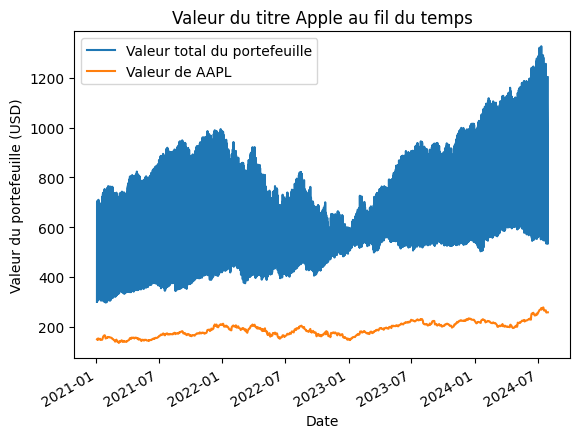

In [191]:
# Calculer la valeur totale du portefeuille
portfolio_value = pd.concat([data['Value'] for data in portfolio_history.values()], axis=1).sum(axis=1)

# Afficher la croissance du portefeuille
portfolio_value.plot(title='Valeur du portefeuille au fil du temps', ylabel='Valeur du portefeuille (USD)',  label='Valeur total du portefeuille', legend=True)

portfolio_history['AAPL']['Value'].plot(title='Valeur du titre Apple au fil du temps', ylabel='Valeur du portefeuille (USD)', label='Valeur de AAPL', legend=True)

plt.show()

## Récupérer les secteurs et pays d'activité des entreprises

In [192]:
portfolio_info = {}

for stock in  liste_tickers:
    sector = stock.info.get('sector')
    country = stock.info.get('country')
    portfolio_info[stock.info.get('symbol')] = {'sector': sector, 'country': country}

## Créer un mapping entre les noms de pays proposés par geopandas et yfinance

In [193]:
def levenshtein_distance(s1, s2):
    # Calcule la distance de Levenshtein entre deux chaînes de caractères
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]

In [194]:
def jaccard_similarity(s1, s2):
    # Calcule la similarité de Jaccard entre deux ensembles
    intersection = len(s1.intersection(s2))
    union = len(s1.union(s2))
    return intersection / union

In [195]:
def find_closest_country_L(target_country, country_series):
    # Trouve le pays le plus proche du nom de pays donné dans la série de pays
    min_distance = float('inf')
    closest_country = None

    for country in country_series:
        distance = levenshtein_distance(target_country.lower(), country.lower())
        if distance < min_distance:
            min_distance = distance
            closest_country = country

    return closest_country

def find_closest_country_J(target_country, country_series):
    # Trouve le pays le plus proche du nom de pays donné dans la série de pays
    max_similarity = 0
    closest_country = None

    target_country_set = set(target_country.lower().split())

    for country in country_series:
        country_set = set(country.lower().split())
        similarity = jaccard_similarity(target_country_set, country_set)
        if similarity > max_similarity:
            max_similarity = similarity
            closest_country = country

    return closest_country

In [196]:
def find_country_containing_target(target_country, country_series):
    # Trouve le pays de la liste qui contient le nom de pays donné
    for country in country_series:
        if target_country.lower() in country.lower():
            return country
    return None

In [197]:
# Créer une liste de dictionnaires avec les informations nécessaires
data = []


# Série de pays
world = gpd.read_file('../data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
countries = world['ADMIN']

for stock, weight in zip(liste_code_stocks, liste_repartition_stocks):
    country = portfolio_info[stock]['country']
    data.append({'stock': stock, 'country': find_country_containing_target(country, countries), 'weight': weight})

# Convertir la liste de dictionnaires en DataFrame
df_portfolio_world = pd.DataFrame(data)

# Afficher le DataFrame
print(df_portfolio_world)

    stock                   country  weight
0    AAPL  United States of America      15
1    MSFT  United States of America      15
2    AMZN  United States of America      15
3   MC.PA                    France      15
4  TTE.PA                    France      15
5   GOOGL  United States of America      15
6    META  United States of America      10


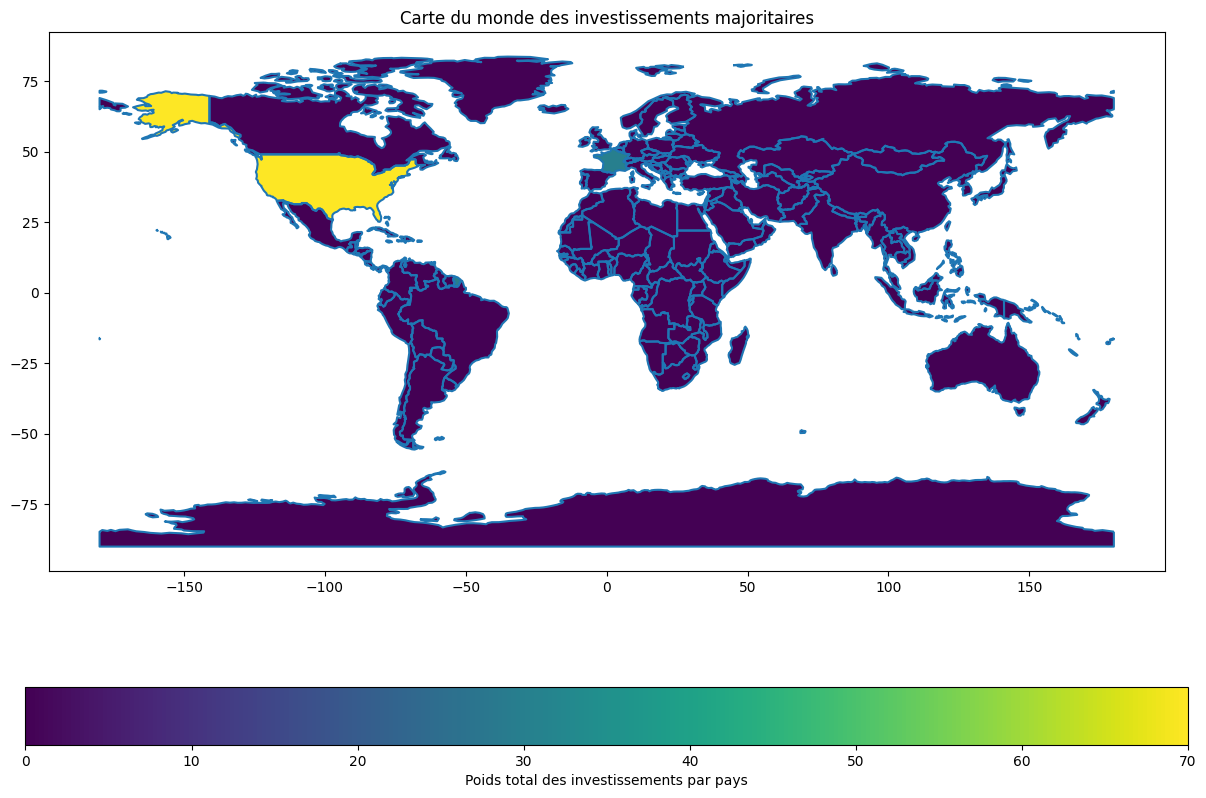

In [198]:
# Calculer la somme des poids pour chaque pays
country_weights = df_portfolio_world.groupby('country')['weight'].sum()

# Ajouter une colonne 'investments' au GeoDataFrame 'world' avec le poids total des investissements par pays
world['investments'] = world['ADMIN'].map(country_weights).fillna(0)

# Créer la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax)
world.plot(column='investments', ax=ax, legend=True, 
           legend_kwds={'label': "Poids total des investissements par pays",
                        'orientation': "horizontal"})

plt.title("Carte du monde des investissements majoritaires")
plt.show()

In [199]:
aapl = yf.Ticker("GOOGL")
print(aapl.info)

{'address1': '1600 Amphitheatre Parkway', 'city': 'Mountain View', 'state': 'CA', 'zip': '94043', 'country': 'United States', 'phone': '650 253 0000', 'website': 'https://abc.xyz', 'industry': 'Internet Content & Information', 'industryKey': 'internet-content-information', 'industryDisp': 'Internet Content & Information', 'sector': 'Communication Services', 'sectorKey': 'communication-services', 'sectorDisp': 'Communication Services', 'longBusinessSummary': 'Alphabet Inc. offers various products and platforms in the United States, Europe, the Middle East, Africa, the Asia-Pacific, Canada, and Latin America. It operates through Google Services, Google Cloud, and Other Bets segments. The Google Services segment provides products and services, including ads, Android, Chrome, devices, Gmail, Google Drive, Google Maps, Google Photos, Google Play, Search, and YouTube. It is also involved in the sale of apps and in-app purchases and digital content in the Google Play and YouTube; and devices,